# Exploratory Data Analysis (EDA)




In [1]:
pip install xgboost

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import statistics as st
import seaborn as sns
import time
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, f1_score, recall_score, precision_score, make_scorer

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Mengecek data

In [3]:
df = pd.read_csv('/content/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
print("Dataset berukuran {} baris dan {} kolom".format(df.shape[0], df.shape[1]))

Dataset berukuran 10000 baris dan 14 kolom


In [5]:
len(df[df['Exited']==1])

2037

In [6]:
len(df[df['Exited']==0])

7963

In [7]:
print("Presentase label 1 adalah {:.2%}".format(2038/df.shape[0]))
print("Presentase label 0 adalah {:.2%}".format(7964/df.shape[0]))

# data nampaknya tidak setimbang (imbalanced)

Presentase label 1 adalah 20.38%
Presentase label 0 adalah 79.64%


In [8]:
# Cek Nan
# Fungsi missing check
# Fungsi ini digunakan untuk mengecek jumlah missing value, keunikan tiap kolom
def missing_check(df) :
    wadah = []
    for i in df.columns :
        wadah.append(df[i].unique())
    missing = df.isnull().sum()
    per_miss = missing/len(df)
    data_type = df.dtypes
    number_unique = df.nunique()
    return pd.DataFrame({"Missing":missing,
                        "Percent_Missing":per_miss,
                        "Data_Types":data_type,
                        "Number_of_unique":number_unique,
                        "Unique":wadah}).style.format({'Percent_Missing': "{:.2%}"})
missing_check(df)

,Missing,Percent_Missing,Data_Types,Number_of_unique,Unique
RowNumber,0,0.00%,int64,10000,[ 1 2 3 ... 9998 9999 10000]
CustomerId,0,0.00%,int64,10000,[15634602 15647311 15619304 ... 15584532 15682355 15628319]
Surname,0,0.00%,object,2932,['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
CreditScore,0,0.00%,int64,460,[619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593 801 611 802 745 483 690 492 709 705 560 752 701 537 487 596 702 486 724 548 464 790 534 748 494 590 468 509 818 816 536 753 774 621 569 658 798 641 542 692 639 765 570 638 599 632 779 527 564 833 504 842 508 417 598 741 607 761 848 546 439 755 760 526 713 700 666 566 495 688 612 477 427 839 819 720 459 503 624 529 563 482 796 445 746 786 554 672 787 499 844 450 815 838 803 736 633 600 679 517 792 743 488 421 841 708 507 505 456 435 561 518 565 728 784 552 609 764 697 723 551 444 719 496 541 830 812 677 420 595 617 809 500 826 434 513 478 797 363 399 463 780 452 575 837 794 824 428 823 781 849 489 431 457 768 831 359 820 573 576 558 817 449 440 415 821 530 350 446 425 740 481 783 358 845 451 458 469 423 404 836 473 835 466 491 351 827 843 365 532 414 453 471 401 810 832 470 447 422 825 430 436 426 408 847 418 437 410 454 407 455 462 386 405 383 395 467 433 442 424 448 441 367 412 382 373 419]
Geography,0,0.00%,object,3,['France' 'Spain' 'Germany']
Gender,0,0.00%,object,2,['Female' 'Male']
Age,0,0.00%,int64,70,[42 41 39 43 44 50 29 27 31 24 34 25 35 45 58 32 38 46 36 33 40 51 61 49 37 19 66 56 26 21 55 75 22 30 28 65 48 52 57 73 47 54 72 20 67 79 62 53 80 59 68 23 60 70 63 64 18 82 69 74 71 76 77 88 85 84 78 81 92 83]
Tenure,0,0.00%,int64,11,[ 2 1 8 7 4 6 3 10 5 9 0]
Balance,0,0.00%,float64,6382,[ 0. 83807.86 159660.8 ... 57369.61 75075.31 130142.79]
NumOfProducts,0,0.00%,int64,4,[1 3 2 4]


In [9]:
#melihat statistikal data
df.describe()

#potensi outlier di kolom BALANCE

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# Mengatasi Nan

In [10]:
# sebelum di boxplot, cek banyak baris yang kosong
# Menampilkan baris yang mengandung NaN
rows_with_nan = df[df.isnull().any(axis=1)]
rows_with_nan

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [11]:
#karena hanya ada 4 baris yang mengandung Nan, dianggap tidak masalah karena kecil jadi kami langsung drop saja
df_cleaned = df.dropna()
missing_check(df_cleaned)

,Missing,Percent_Missing,Data_Types,Number_of_unique,Unique
RowNumber,0,0.00%,int64,10000,[ 1 2 3 ... 9998 9999 10000]
CustomerId,0,0.00%,int64,10000,[15634602 15647311 15619304 ... 15584532 15682355 15628319]
Surname,0,0.00%,object,2932,['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
CreditScore,0,0.00%,int64,460,[619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593 801 611 802 745 483 690 492 709 705 560 752 701 537 487 596 702 486 724 548 464 790 534 748 494 590 468 509 818 816 536 753 774 621 569 658 798 641 542 692 639 765 570 638 599 632 779 527 564 833 504 842 508 417 598 741 607 761 848 546 439 755 760 526 713 700 666 566 495 688 612 477 427 839 819 720 459 503 624 529 563 482 796 445 746 786 554 672 787 499 844 450 815 838 803 736 633 600 679 517 792 743 488 421 841 708 507 505 456 435 561 518 565 728 784 552 609 764 697 723 551 444 719 496 541 830 812 677 420 595 617 809 500 826 434 513 478 797 363 399 463 780 452 575 837 794 824 428 823 781 849 489 431 457 768 831 359 820 573 576 558 817 449 440 415 821 530 350 446 425 740 481 783 358 845 451 458 469 423 404 836 473 835 466 491 351 827 843 365 532 414 453 471 401 810 832 470 447 422 825 430 436 426 408 847 418 437 410 454 407 455 462 386 405 383 395 467 433 442 424 448 441 367 412 382 373 419]
Geography,0,0.00%,object,3,['France' 'Spain' 'Germany']
Gender,0,0.00%,object,2,['Female' 'Male']
Age,0,0.00%,int64,70,[42 41 39 43 44 50 29 27 31 24 34 25 35 45 58 32 38 46 36 33 40 51 61 49 37 19 66 56 26 21 55 75 22 30 28 65 48 52 57 73 47 54 72 20 67 79 62 53 80 59 68 23 60 70 63 64 18 82 69 74 71 76 77 88 85 84 78 81 92 83]
Tenure,0,0.00%,int64,11,[ 2 1 8 7 4 6 3 10 5 9 0]
Balance,0,0.00%,float64,6382,[ 0. 83807.86 159660.8 ... 57369.61 75075.31 130142.79]
NumOfProducts,0,0.00%,int64,4,[1 3 2 4]


In [12]:
#cek banyak baris
df_cleaned

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


# Mengatasi Duplikat

In [13]:
#mengecek baris duplikat.
duplicate_rows_including_first = df_cleaned[df_cleaned.duplicated(keep=False)]
duplicate_rows_including_first

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [14]:
#drop duplikat baris
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


# Encoding

In [15]:
# Sebelum melakukan encoding, kita drop dulu colom yang mungkin tidak terlalu berpengaruh seperti CustomerId
df_cleaned = df_cleaned.drop('CustomerId', axis=1)
df_cleaned


,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [16]:
dfx = df_cleaned

In [17]:
#Label Encoder untuk gender
# Menginisialisasi LabelEncoder
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

# Melakukan Label Encoding pada kolom 'Gender'
dfx['Gender'] = labelencoder.fit_transform(dfx['Gender'])
dfx

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,3,Onio,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,4,Boni,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,5,Mitchell,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,Obijiaku,771,France,1,39,5,0.00,2,1,0,96270.64,0
9996,9997,Johnstone,516,France,1,35,10,57369.61,1,1,1,101699.77,0
9997,9998,Liu,709,France,0,36,7,0.00,1,0,1,42085.58,1
9998,9999,Sabbatini,772,Germany,1,42,3,75075.31,2,1,0,92888.52,1


In [18]:
# one hot encoding untuk geografi dan surname, supaya tidak ada kesan urutan

dfx = pd.get_dummies(dfx, columns=['Geography', 'Surname'], drop_first=True)
dfx

,RowNumber,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zinachukwudi,Surname_Zito,Surname_Zotov,Surname_Zotova,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva
0,1,619,0,42,2,0.00,1,1,1,101348.88,...,False,False,False,False,False,False,False,False,False,False
1,2,608,0,41,1,83807.86,1,0,1,112542.58,...,False,False,False,False,False,False,False,False,False,False
2,3,502,0,42,8,159660.80,3,1,0,113931.57,...,False,False,False,False,False,False,False,False,False,False
3,4,699,0,39,1,0.00,2,0,0,93826.63,...,False,False,False,False,False,False,False,False,False,False
4,5,850,0,43,2,125510.82,1,1,1,79084.10,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,771,1,39,5,0.00,2,1,0,96270.64,...,False,False,False,False,False,False,False,False,False,False
9996,9997,516,1,35,10,57369.61,1,1,1,101699.77,...,False,False,False,False,False,False,False,False,False,False
9997,9998,709,0,36,7,0.00,1,0,1,42085.58,...,False,False,False,False,False,False,False,False,False,False
9998,9999,772,1,42,3,75075.31,2,1,0,92888.52,...,False,False,False,False,False,False,False,False,False,False


In [19]:
dfx.set_index('RowNumber', inplace=True)

In [20]:
dfx

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,Surname_Zinachukwudi,Surname_Zito,Surname_Zotov,Surname_Zotova,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva
RowNumber,,,,,,,,,,,,,,,,,,,,,
1,619,0,42,2,0.00,1,1,1,101348.88,1,...,False,False,False,False,False,False,False,False,False,False
2,608,0,41,1,83807.86,1,0,1,112542.58,0,...,False,False,False,False,False,False,False,False,False,False
3,502,0,42,8,159660.80,3,1,0,113931.57,1,...,False,False,False,False,False,False,False,False,False,False
4,699,0,39,1,0.00,2,0,0,93826.63,0,...,False,False,False,False,False,False,False,False,False,False
5,850,0,43,2,125510.82,1,1,1,79084.10,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,771,1,39,5,0.00,2,1,0,96270.64,0,...,False,False,False,False,False,False,False,False,False,False
9997,516,1,35,10,57369.61,1,1,1,101699.77,0,...,False,False,False,False,False,False,False,False,False,False
9998,709,0,36,7,0.00,1,0,1,42085.58,1,...,False,False,False,False,False,False,False,False,False,False


# Membagi data untuk split train dan test

In [21]:
# Pisahkan fitur (X) dan target (y)
X = dfx.drop('Exited', axis=1)  # Semua kolom kecuali 'Exited'
y = dfx['Exited']  # Kolom target 'Exited'

# Membagi data menjadi train dan test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)


# Outlier

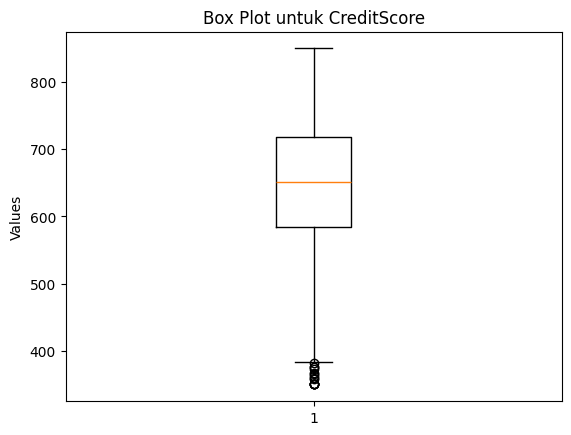

Kolom CreditScore:
  Jumlah Outlier: 15
  Persentase Outlier: 0.15%
------------------------------


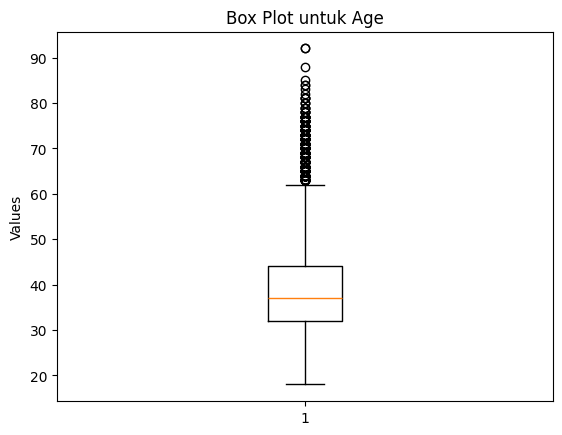

Kolom Age:
  Jumlah Outlier: 359
  Persentase Outlier: 3.59%
------------------------------


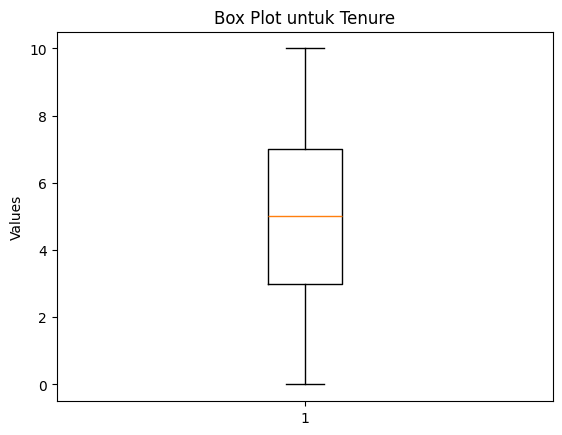

Kolom Tenure:
  Jumlah Outlier: 0
  Persentase Outlier: 0.00%
------------------------------


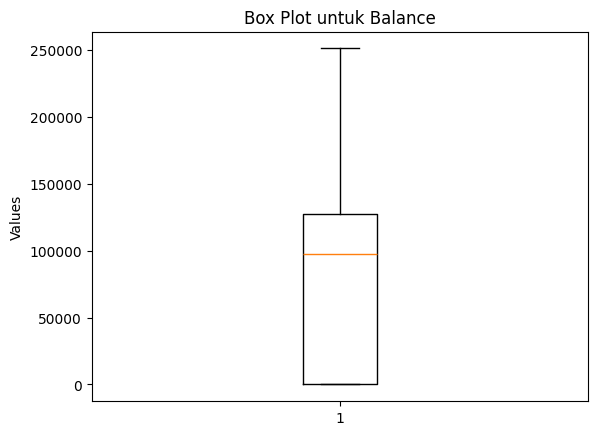

Kolom Balance:
  Jumlah Outlier: 0
  Persentase Outlier: 0.00%
------------------------------


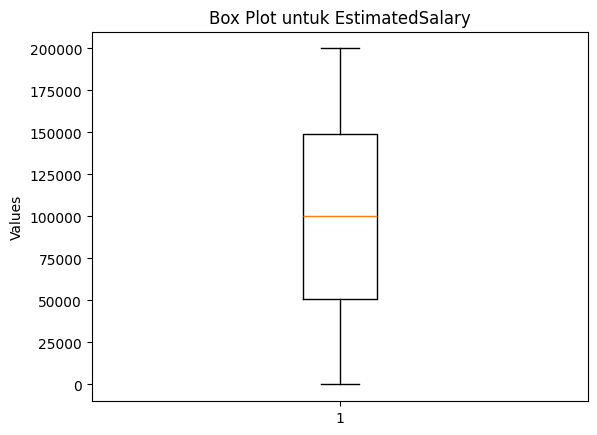

Kolom EstimatedSalary:
  Jumlah Outlier: 0
  Persentase Outlier: 0.00%
------------------------------


In [22]:
# Daftar kolom dan label
columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
labels = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

# Fungsi untuk menghitung outlier
def calculate_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers.sum(), outliers.sum() / len(data) * 100  # Jumlah dan persentase outlier


# Membuat setiap box plot di jendela berbeda
for col, label in zip(columns, labels):
    plt.figure()  # Membuat figure baru
    plt.boxplot(dfx[col])
    plt.title(f'Box Plot untuk {label}')
    plt.ylabel('Values')
    plt.show()
    count, percentage = calculate_outliers(dfx[col])
    print(f"Kolom {col}:")
    print(f"  Jumlah Outlier: {count}")
    print(f"  Persentase Outlier: {percentage:.2f}%")
    print("-" * 30)


#### karena ada outlier, akan di coba dilakukan scaling pada data - data diatas


#### pertama akan di cek apakah data normal atau tidak sebelum scaling,


#### jika tidak, tidak digunakan normal scaling tetapi MinMaxScaling

#### Scaling dilakukan pada data yang sudah dibagi untuk train dan test

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


CreditScore: Statistik = 0.994, p-value = 0.000
Kolom CreditScore kemungkinan tidak berdistribusi normal.

Age: Statistik = 0.944, p-value = 0.000
Kolom Age kemungkinan tidak berdistribusi normal.

Tenure: Statistik = 0.949, p-value = 0.000
Kolom Tenure kemungkinan tidak berdistribusi normal.

Balance: Statistik = 0.846, p-value = 0.000
Kolom Balance kemungkinan tidak berdistribusi normal.

EstimatedSalary: Statistik = 0.957, p-value = 0.000
Kolom EstimatedSalary kemungkinan tidak berdistribusi normal.



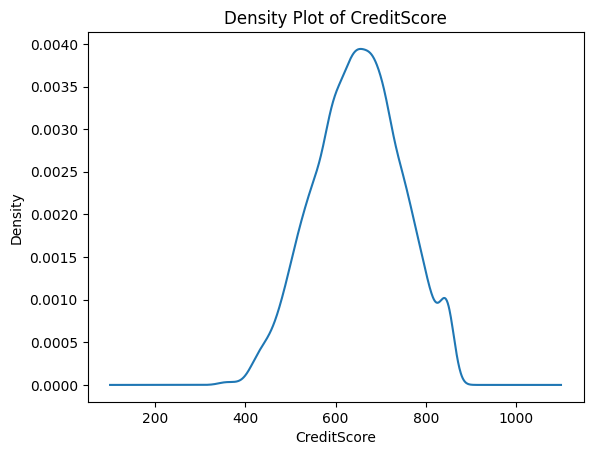

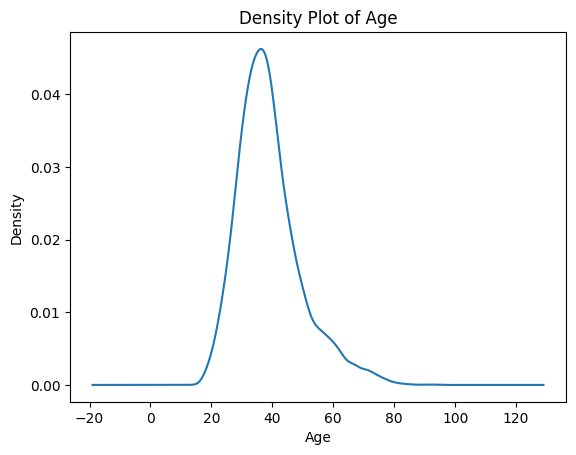

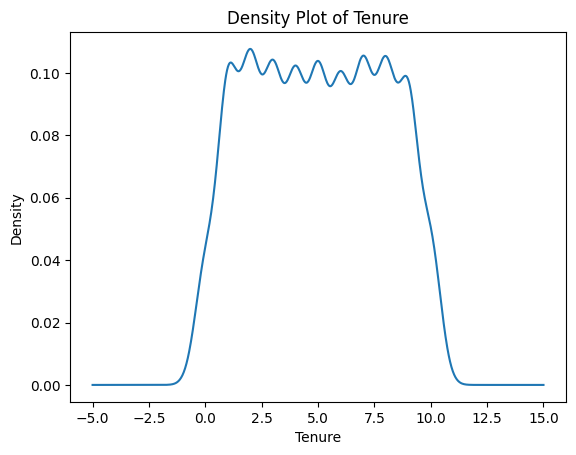

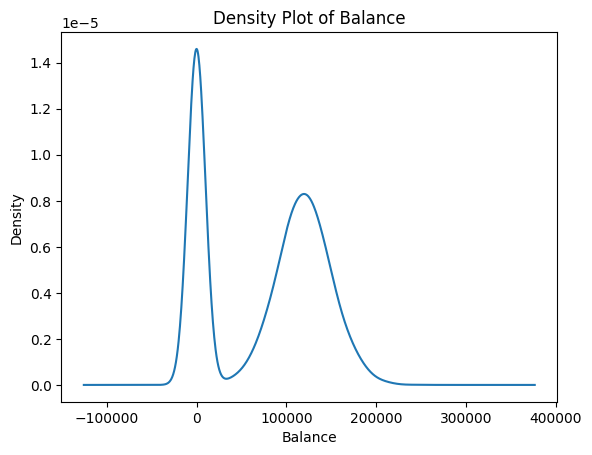

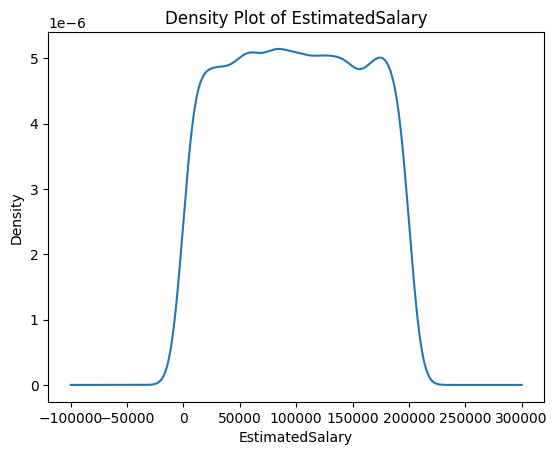

In [23]:
# cek normalitas
from scipy.stats import shapiro

columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
# Uji Shapiro-Wilk
for col in columns:
    stat, p = shapiro(dfx[col])
    print(f"{col}: Statistik = {stat:.3f}, p-value = {p:.3f}")
    if p > 0.05:
        print(f"Kolom {col} kemungkinan berdistribusi normal.\n")
    else:
        print(f"Kolom {col} kemungkinan tidak berdistribusi normal.\n")

for col in columns:
    plt.figure()
    dfx[col].plot(kind='density')
    plt.title(f'Density Plot of {col}')
    plt.xlabel(col)
    plt.show()

In [25]:
from sklearn.preprocessing import MinMaxScaler
# Kolom yang ingin di-scaling
columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Terapkan Min-Max Scaling hanya pada kolom yang diinginkan
X_train_scaled = X_train.copy()  # Salin X_train agar tidak mempengaruhi X_train asli
X_test_scaled = X_test.copy()  # Salin X_test agar tidak mempengaruhi X_test asli

# Terapkan scaling hanya pada kolom-kolom yang ada dalam `columns`
X_train_scaled[columns] = scaler.fit_transform(X_train[columns])
X_test_scaled[columns] = scaler.transform(X_test[columns])

# Menampilkan hasil
print("Data Train setelah MinMax Scaling pada kolom tertentu:")
print(X_train_scaled) # <--- yang dimasukin ke model
print("\nData Test setelah MinMax Scaling pada kolom tertentu:")
print(X_test_scaled)

Data Train setelah MinMax Scaling pada kolom tertentu:
           CreditScore  Gender       Age  Tenure   Balance  NumOfProducts  \
RowNumber                                                                   
8277             0.460       1  0.189189     0.9  0.566717              2   
9289             0.570       0  0.243243     0.9  0.323764              2   
531              0.338       0  0.527027     0.2  0.474437              2   
8128             0.602       1  0.229730     0.8  0.438695              1   
9904             0.512       0  0.243243     1.0  0.000000              2   
...                ...     ...       ...     ...       ...            ...   
2495             0.632       1  0.378378     0.5  0.493719              1   
2689             0.416       1  0.189189     0.4  0.431394              1   
2657             0.858       0  0.216216     0.5  0.000000              2   
3579             0.708       0  0.283784     0.1  0.496777              1   
7817             0.84